# MIDST Challenge
Black-box MIA on single table

# Import packages

In [1]:
import sys

sys.path.append("..")

from pathlib import Path

import pandas as pd
from clover.generators.findiff_generator import FinDiffGenerator
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from src.attack import (
    LOGAN,
    Detector,
    Ensemble,
    GAN_Leaks,
    Monte_Carlo,
    TableGAN,
    blending,
    blending_plus,
    soft_voting,
    stacking,
    stacking_plus,
)

# 1.Configuration

In [2]:
# Paths

data_dir = Path("/data8/projets/dev_synthetic_data/data/MIDST")
output_dir = Path("/data8/projets/dev_synthetic_data/output/MIDST")

# 2.Data

## 2.1 Population
Collect all the real data used to train TabDDPM

In [3]:
for i in range(1, 31):
    data_dir_ith = (
        data_dir / "tabddpm_black_box" / "train" / f"tabddpm_{i}" / "train_with_id.csv"
    )
    df_real_ith = pd.read_csv(data_dir_ith)

    if i == 1:
        df_real = df_real_ith
    else:
        df_real = pd.concat([df_real, df_real_ith])

In [4]:
df_real = df_real.drop_duplicates()

In [5]:
df_real.shape

(460972, 10)

In [6]:
df_real.head()

,trans_id,account_id,trans_date,trans_type,operation,amount,balance,k_symbol,bank,account
0,707363,2423,1377,2,1,1494.0,14377.4,5,6,35182595
1,867043,2951,1154,2,4,14.6,35891.2,6,0,0
2,417654,1416,282,2,4,37800.0,66826.9,1,0,0
3,619464,2114,2098,2,4,5400.0,17284.3,1,0,0
4,188479,638,2048,2,1,2487.0,28732.4,5,9,41244357


## 2.2 Real data
Take synthetic data generated by **tabddpm_1** as example

In [7]:
# Training data

real_dir_1st = (
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "train_with_id.csv"
)
df_real_train = pd.read_csv(real_dir_1st)

In [8]:
df_real_train.shape

(20000, 10)

In [9]:
# Real control

df_real_control = df_real[~df_real["trans_id"].isin(df_real_train["trans_id"])]

In [10]:
# Sample a fraction

df_real_control = df_real_control.sample(
    n=int(len(df_real_train) * 1.5), replace=False, ignore_index=True, random_state=None
)

In [11]:
# Further split the control:
#   - One portion used to train detector
#   - One portion used as part of the validation set for ensemble model
#   - One portion used to construct the test set to evaluate the final model

df_real_control_detector, df_real_control_rest = train_test_split(
    df_real_control, test_size=1 / 3, random_state=None
)

df_real_control_val, df_real_control_test = train_test_split(
    df_real_control_rest, test_size=0.5, random_state=None
)

In [12]:
# Drop ids

df_real_train = df_real_train.drop(columns=["trans_id", "account_id"])
df_real_control_detector = df_real_control_detector.drop(
    columns=["trans_id", "account_id"]
)
df_real_control_val = df_real_control_val.drop(columns=["trans_id", "account_id"])
df_real_control_test = df_real_control_test.drop(columns=["trans_id", "account_id"])

In [55]:
# Type convertion

for col in metadata["categorical"]:
    df_real_train[col] = df_real_train[col].astype("object")
    df_real_control_detector[col] =df_real_control_detector[col].astype("object")
    df_real_control_val[col] = df_real_control_val[col].astype("object")
    df_real_control_test[col] = df_real_control_test[col].astype("object")

## 2.2 Synthetic data
We used **FinDiff** as example to generate 1st and 2nd generation synthetic data

In [13]:
# Metadata of the dataset

metadata = {
    "continuous": ["trans_date", "amount", "balance", "bank"],
    "categorical": ["trans_type", "operation", "k_symbol", "account"],
    "variable_to_predict": "trans_type",
}

In [ ]:
# Train generator

gen = FinDiffGenerator(
    df=df_real_train,
    metadata=metadata,
    random_state=None,
    generator_filepath=None,
    learning_rate=1e-3,
    batch_size=256,
    diffusion_steps=500,
    epochs=500,
    mpl_layers=[1024, 1024, 1024, 1024],
    activation="lrelu",
    dim_t=64,
    cat_emb_dim=2,
    diff_beta_start_end=[1e-4, 0.02],
    scheduler="linear",
    epsilon=None,
)

gen.preprocess()
gen.fit(save_path=output_dir / "tabddpm_1" / "1st_gen")  # the path should exist

In [40]:
# Generate 1st geneartion synthetic data

df_synth_train = gen.sample(
    save_path=output_dir / "tabddpm_1" / "1st_gen",
    num_samples=len(df_real_train) * 2,
)

df_synth_test = gen.sample(
    save_path=output_dir / "tabddpm_1" / "1st_gen",
    num_samples=len(df_real_train),
)

In [15]:
# Load the synthetic data if always generated 

# df_synth_train = pd.read_csv(output_dir / "tabddpm_1" / "1st_gen" / "2025-01-21_FinDiff_40000samples.csv")
# df_synth_test = pd.read_csv(output_dir / "tabddpm_1" / "1st_gen" / "2025-01-21_FinDiff_20000samples.csv")

In [41]:
# Generate 2nd generation synthetic data

gen_2nd = FinDiffGenerator(
    df=df_synth_train,
    metadata=metadata,
    random_state=None,
    generator_filepath=None,
    learning_rate=1e-3,
    batch_size=256,
    diffusion_steps=500,
    epochs=500,
    mpl_layers=[1024, 1024, 1024, 1024],
    activation="lrelu",
    dim_t=64,
    cat_emb_dim=2,
    diff_beta_start_end=[1e-4, 0.02],
    scheduler="linear",
    epsilon=None,
)

gen_2nd.preprocess()
gen_2nd.fit(save_path=output_dir / "tabddpm_1" / "2nd_gen")  # the path should exist

df_synth_2nd = gen.sample(
    save_path=output_dir / "tabddpm_1" / "2nd_gen",
    num_samples=len(df_real_train),
)

In [16]:
# Load the synthetic data if always generated 

# df_synth_2nd = pd.read_csv(output_dir / "tabddpm_1" / "2nd_gen" / "2025-01-21_FinDiff_20000samples.csv")

In [56]:
# Type convertion

for col in metadata["categorical"]:
    df_synth_train[col] = df_synth_train[col].astype("object")
    df_synth_test[col] = df_synth_test[col].astype("object")
    df_synth_2nd[col] =df_synth_2nd[col].astype("object")

# 3.Membership inference attacks

## 3.1 Prepare inputs for different MIA models
Build train, validation and test sets
- The size of the train set for all the models is the same
- Validation set is only used for ensemble model
- We use the same test set to evaluate each model

In [57]:
cat_cols = [col for col in df_real_train.columns if col not in metadata["continuous"]]
cont_cols = [col for col in df_real_train.columns if col not in cat_cols]

In [58]:
# LOGAN

df_train_logan, y_train_logan = LOGAN.prepare_data(
    df_synth_train=df_synth_train,
    df_synth_2nd=df_synth_2nd,
    size=len(df_real_train),
    cat_cols=cat_cols,
    seed=None,
)

In [59]:
# TableGAN

(
    df_train_tablegan_discriminator,
    y_train_tablegan_discriminator,
    df_train_tablegan_classifier,
    y_train_tablegan_classifier,
) = TableGAN.prepare_data(
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_synth_2nd=df_synth_2nd,
    size=len(df_synth_test),
    cat_cols=cat_cols,
    seed=None,
)

In [60]:
# Detector

df_train_detector, y_train_detector = Detector.prepare_data(
    df_real_control_detector=df_real_control_detector,
    df_synth_train=df_synth_train,
    size=len(df_real_control_detector),
    cat_cols=cat_cols,
    seed=None,
)

In [61]:
# Validation (for ensemble) and test sets

df_val, y_val, _, _ = Ensemble.prepare_data(
    df_real_train=df_real_train,
    df_real_control_val=df_real_control_val,
    df_real_control_test=df_real_control_test,
    cat_cols=cat_cols,
    seed=None,
)

## 3.2 Train and evalute MIA models
Attack models are evaluated with the provided test set

In [62]:
# Load the test set provided in tabddpm_1

df_test = pd.read_csv(
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "challenge_with_id.csv"
)

y_test = pd.read_csv(
    data_dir / "tabddpm_black_box" / "train" / "tabddpm_1" / "challenge_label.csv"
)

In [63]:
# Drop id

df_test = df_test.drop(columns=["trans_id", "account_id"])

In [64]:
# Type convertion

for col in metadata["categorical"]:
    df_test[col] = df_test[col].astype("object")

y_test = y_test["is_train"].to_numpy()

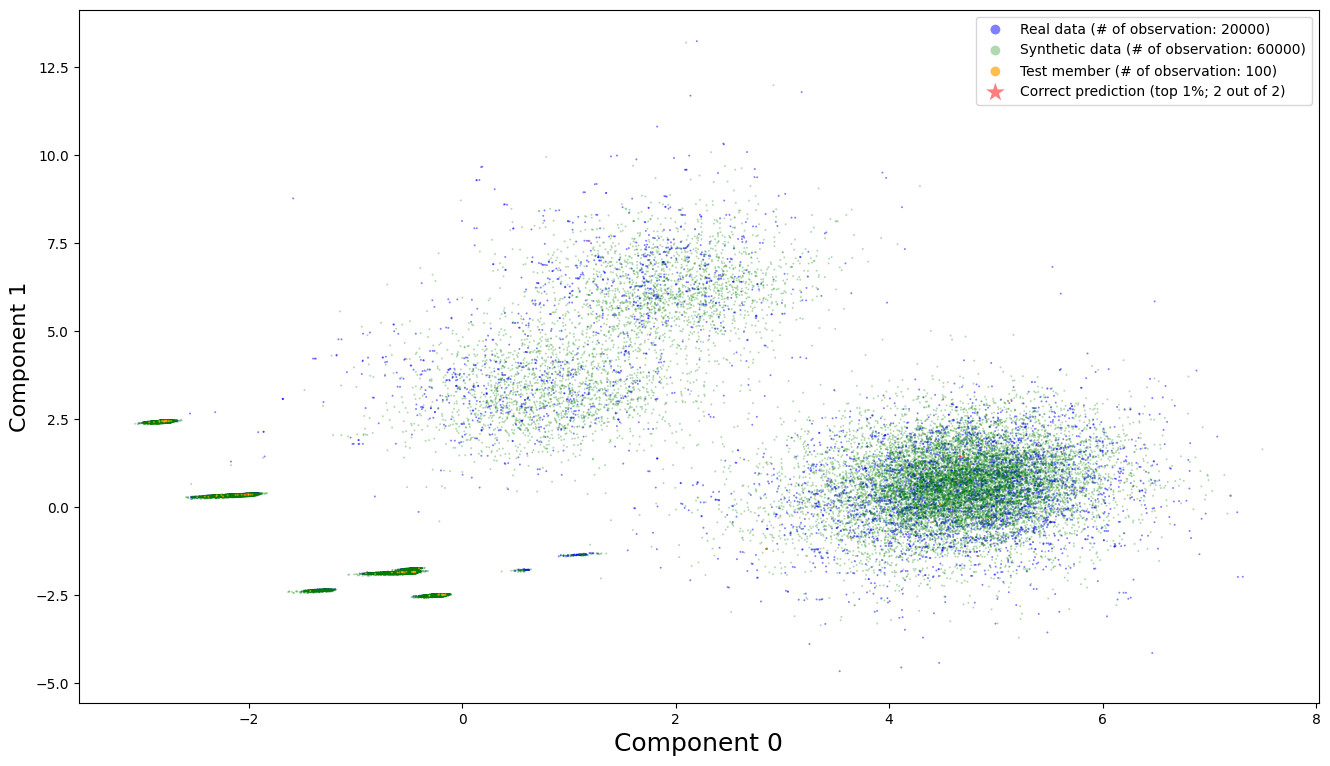

In [65]:
# LOGAN

pred_logan, _, _ = LOGAN.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "logan",
    seed=None,
)

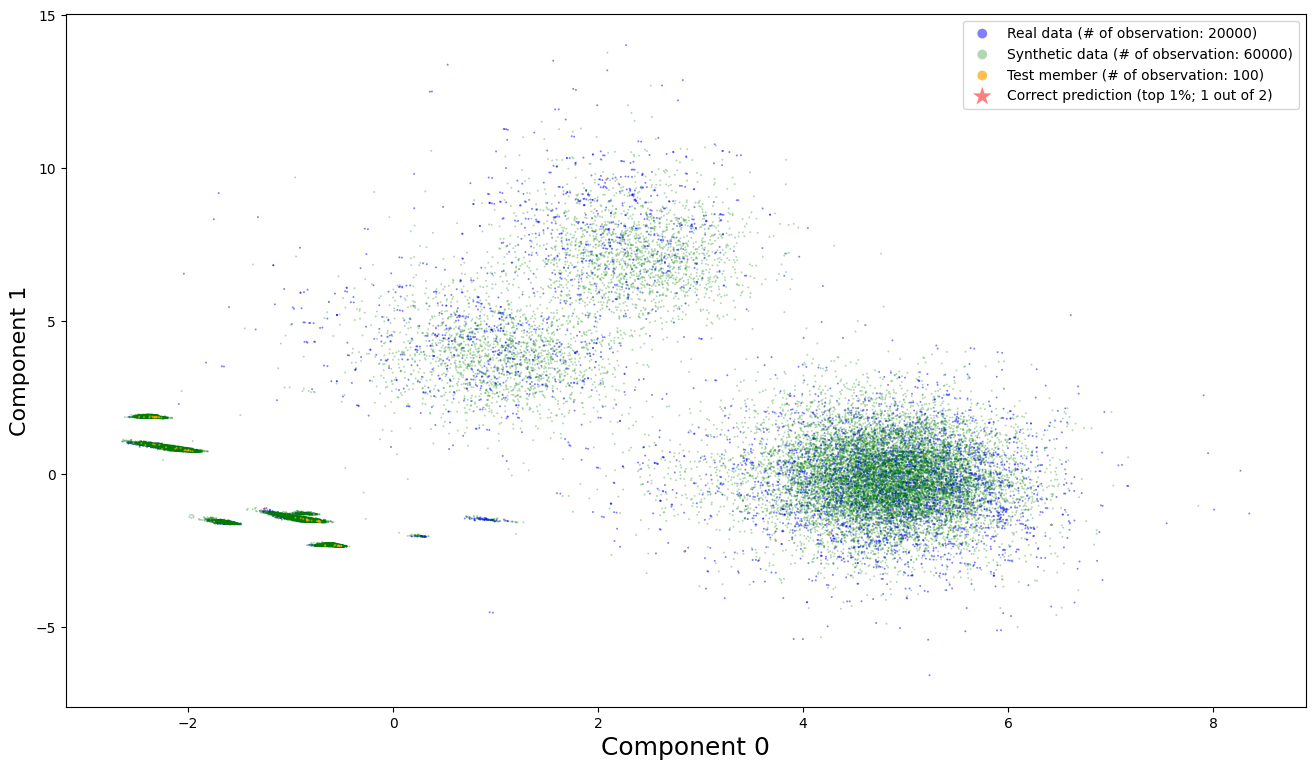

In [66]:
# TableGAN

pred_tablegan, _, _ = TableGAN.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "tablegan",
    seed=None,
)

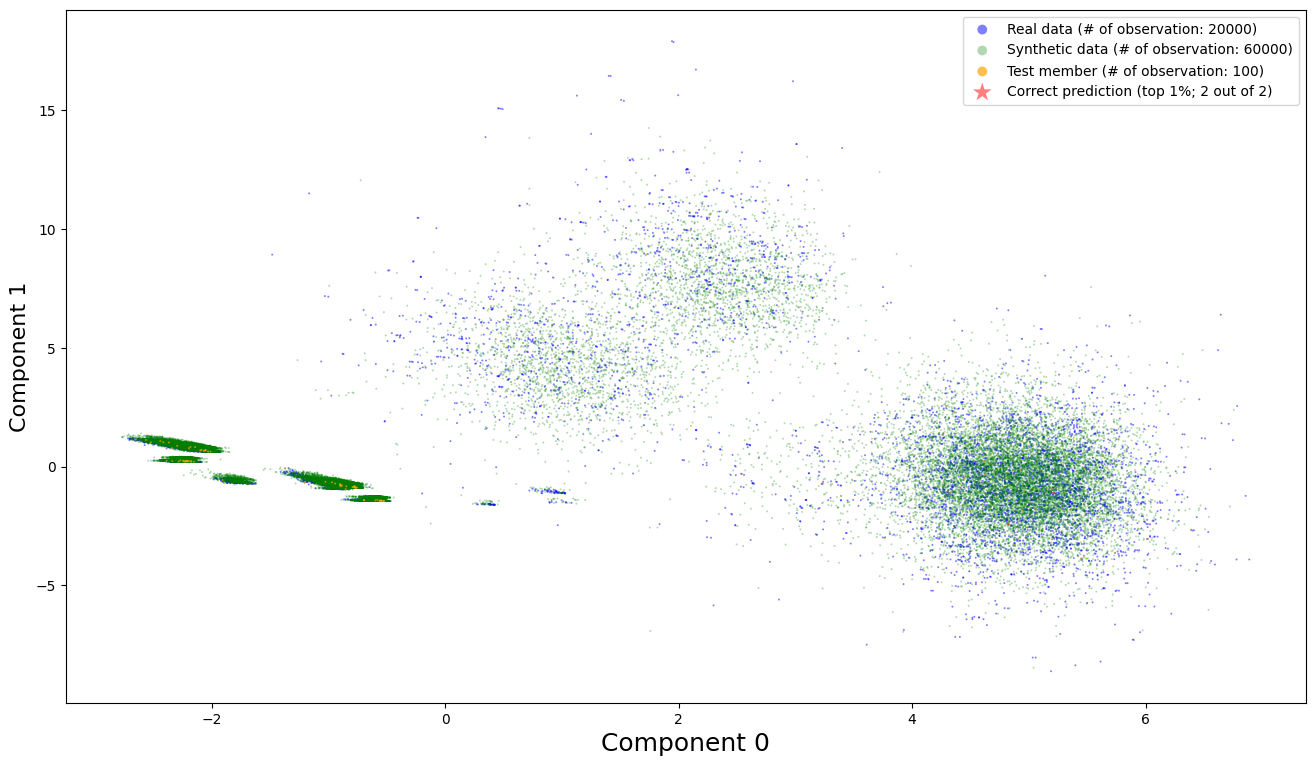

In [67]:
# Detector

pred_detector, _, _ = Detector.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "detector",
    seed=None,
)

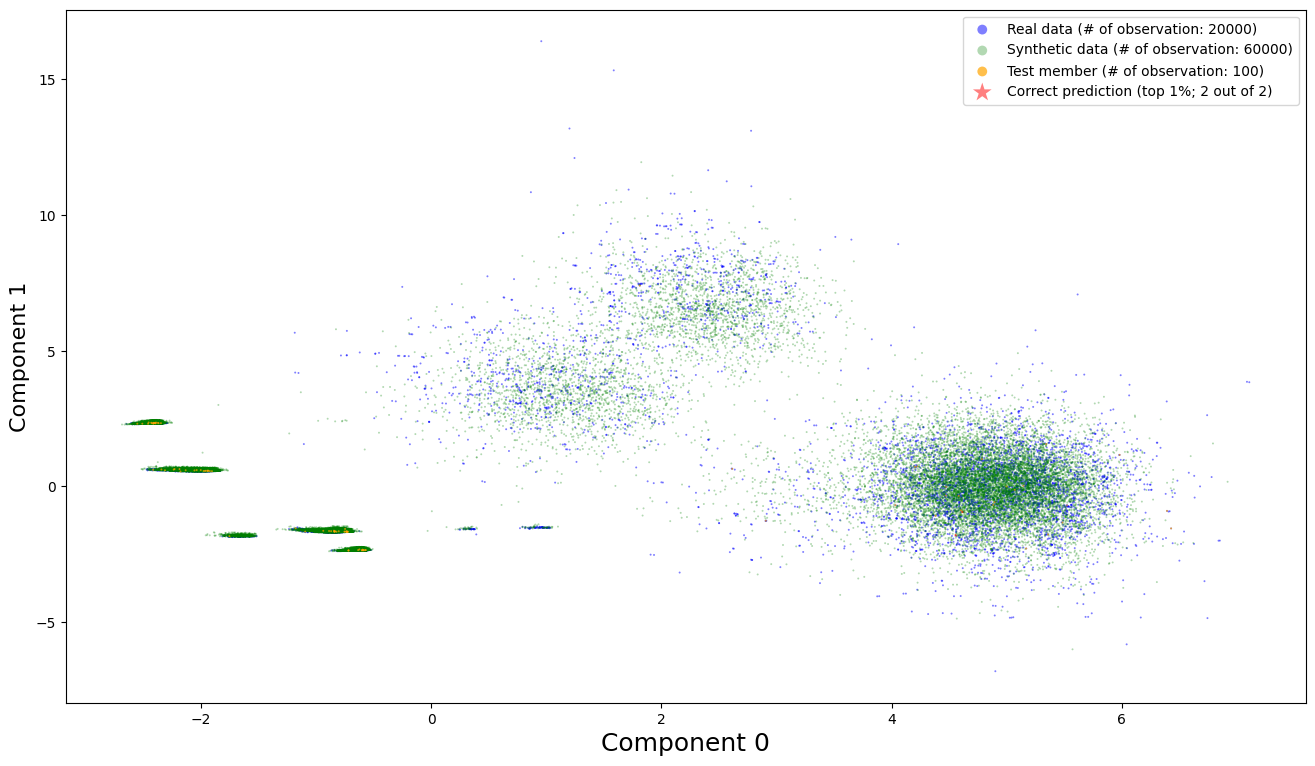

In [68]:
# Soft voting

pred_soft_voting, _, _ = soft_voting.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "soft_voting",
    seed=None,
)

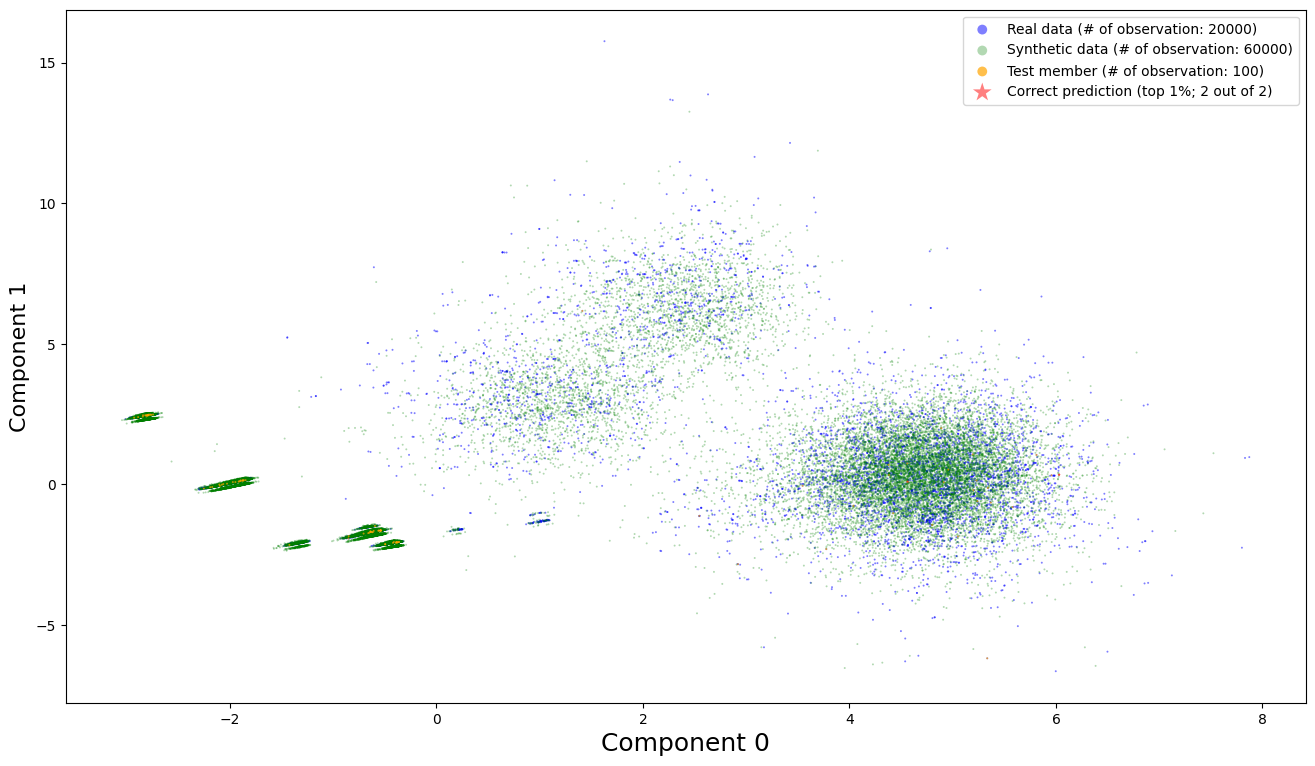

In [69]:
# Stacking

pred_stacking, _, _ = stacking.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_val=df_val,
    y_val=y_val,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "stacking",
    seed=None,
)

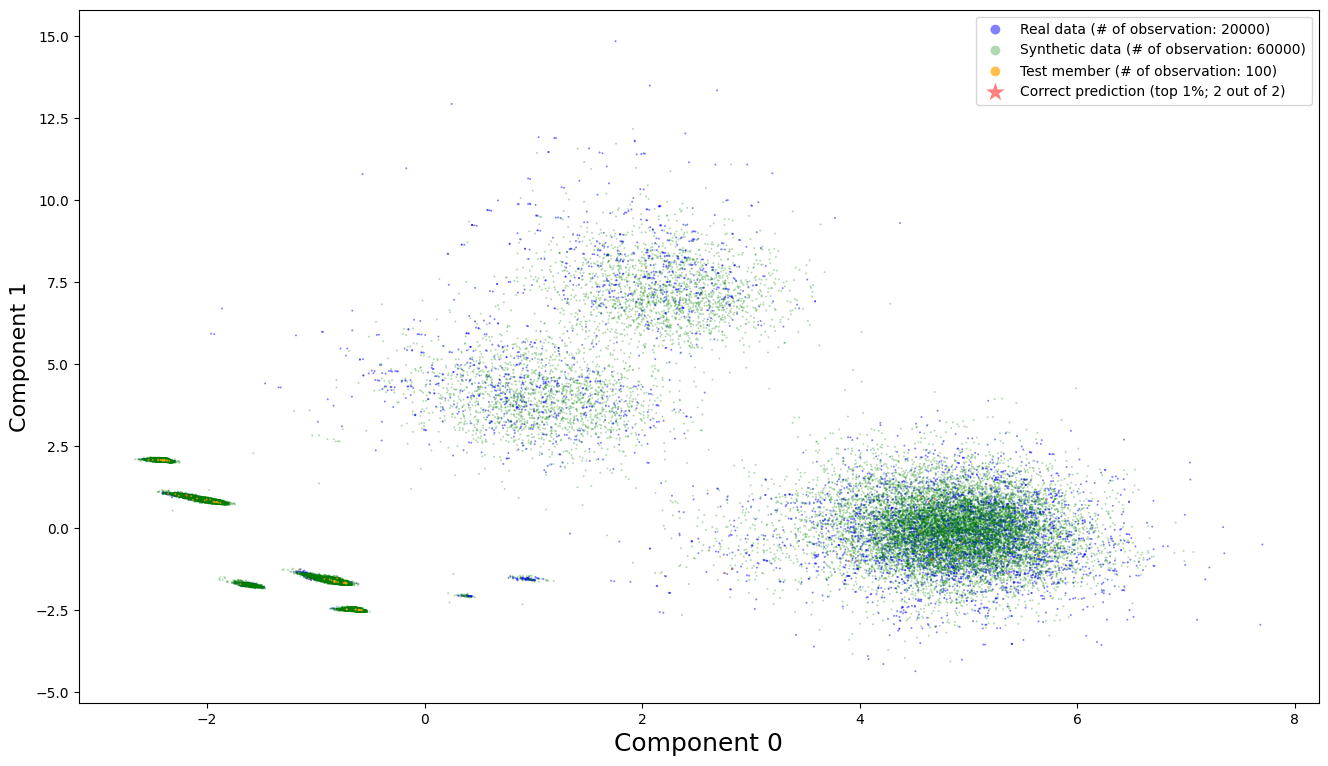

In [70]:
# Stacking+

pred_stacking_plus, _, _ = stacking_plus.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_val=df_val,
    y_val=y_val,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "stacking_plus",
    seed=None,
)

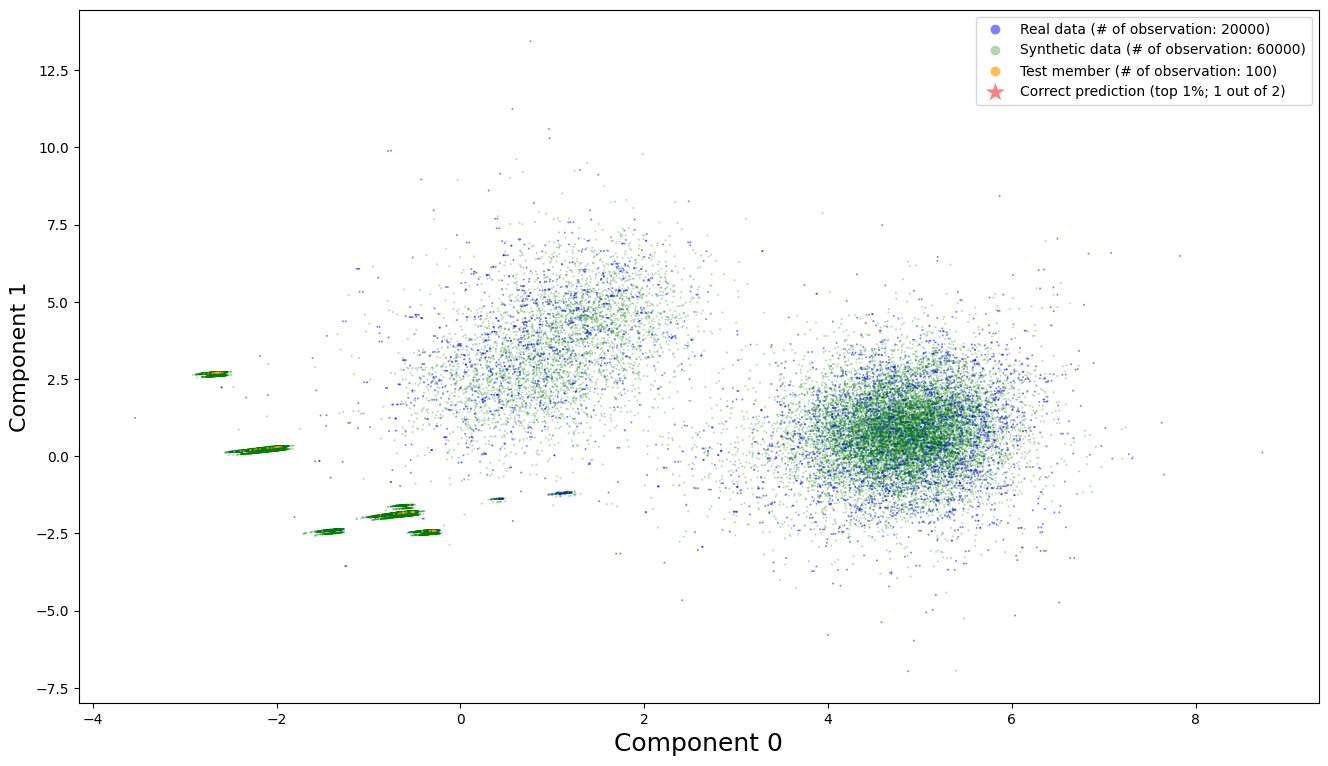

In [71]:
# Blending

pred_blending, _, _ = blending.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_val=df_val,
    y_val=y_val,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "blending",
    seed=None,
)

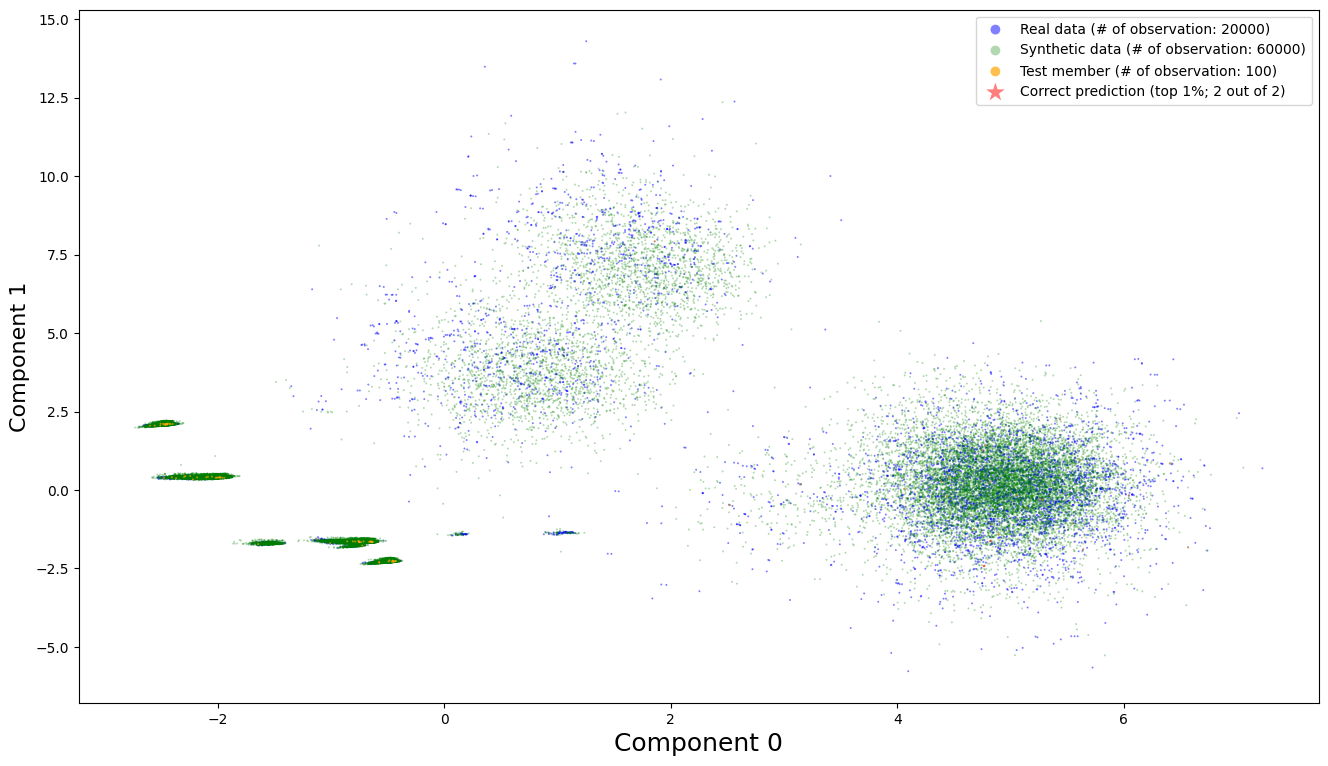

In [72]:
# Blending+

pred_blending_plus, _, _ = blending_plus.model(
    df_real_train=df_real_train,
    df_synth_train=df_synth_train,
    df_synth_test=df_synth_test,
    df_train_logan=df_train_logan,
    y_train_logan=y_train_logan,
    df_train_tablegan_discriminator=df_train_tablegan_discriminator,
    y_train_tablegan_discriminator=y_train_tablegan_discriminator,
    df_train_tablegan_classifier=df_train_tablegan_classifier,
    y_train_tablegan_classifier=y_train_tablegan_classifier,
    df_train_detector=df_train_detector,
    y_train_detector=y_train_detector,
    df_val=df_val,
    y_val=y_val,
    df_test=df_test,
    y_test=y_test,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    iteration=1,
    save_path=output_dir / "tabddpm_1" / "blending_plus",
    seed=None,
)

## 3.3 Attack results

In [73]:
# Function taken from MIDST repo

def get_tpr_at_fpr(true_membership: list, predictions: list, max_fpr=0.1) -> float:
    """Calculates the best True Positive Rate when the False Positive Rate is
    at most `max_fpr`.

    Args:
        true_membership (List): A list of values in {0,1} indicating the membership of a
            challenge point. 0: "non-member", 1: "member".
        predictions (List): A list of values in the range [0,1] indicating the confidence
            that a challenge point is a member. The closer the value to 1, the more
            confident the predictor is about the hypothesis that the challenge point is
            a member.
        max_fpr (float, optional): Threshold on the FPR. Defaults to 0.1.

    Returns:
        float: The TPR @ `max_fpr` FPR.
    """
    fpr, tpr, _ = roc_curve(true_membership, predictions)

    return max(tpr[fpr < max_fpr])

In [75]:
tpr_at_fpr_logan = get_tpr_at_fpr(y_test, pred_logan[0])
tpr_at_fpr_tablegan = get_tpr_at_fpr(y_test, pred_tablegan[0])
tpr_at_fpr_detector = get_tpr_at_fpr(y_test, pred_detector[0])
tpr_at_fpr_soft_voting = get_tpr_at_fpr(y_test, pred_soft_voting[0])
tpr_at_fpr_stacking = get_tpr_at_fpr(y_test, pred_stacking[0])
tpr_at_fpr_stacking_plus = get_tpr_at_fpr(y_test, pred_stacking_plus[0])
tpr_at_fpr_blending = get_tpr_at_fpr(y_test, pred_blending[0])
tpr_at_fpr_blending_plus = get_tpr_at_fpr(y_test, pred_blending_plus[0])

print(f"LOGAN TPR at FPR==10%: {tpr_at_fpr_logan}")
print(f"TableGAN TPR at FPR==10%: {tpr_at_fpr_tablegan}")
print(f"Detector TPR at FPR==10%: {tpr_at_fpr_detector}")
print(f"Soft voting TPR at FPR==10%: {tpr_at_fpr_soft_voting}")
print(f"Stacking TPR at FPR==10%: {tpr_at_fpr_stacking}")
print(f"Stacking+ TPR at FPR==10%: {tpr_at_fpr_stacking_plus}")
print(f"Blending TPR at FPR==10%: {tpr_at_fpr_blending}")
print(f"Blending+ TPR at FPR==10%: {tpr_at_fpr_blending_plus}")

LOGAN TPR at FPR==10%: 0.1
TableGAN TPR at FPR==10%: 0.15
Detector TPR at FPR==10%: 0.1
Soft voting TPR at FPR==10%: 0.06
Stacking TPR at FPR==10%: 0.11
Stacking+ TPR at FPR==10%: 0.13
Blending TPR at FPR==10%: 0.15
Blending+ TPR at FPR==10%: 0.16
